## Task 3: State-of-the-art 

In [ ]:
ANNOTATIONS = 'annotations.xml'
VIDEO = 'vdo.avi'

def parse_xml_not_parked(file_path):
    """
    Parses an XML file and extracts bounding box information for each frame and track.

    Args:
        file_path (str): Path to the XML file.

    Returns:
        tuple: A tuple containing two dictionaries, `tracks` and `frames`.
            `tracks` contains information for each track, with the track IDs as keys and the box information
            for each frame as values.
            `frames` contains information for each frame, with the frame numbers as keys and a list of boxes as
            values.
    """
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    frames = {}

    # Iterate over the tracks and extract their bounding box information
    for track in root.findall(".//track[@label='car']"):

        for box in track.findall(".//box"):
            box_frame = int(box.get('frame'))
            xtl, ytl, xbr, ybr = map(float, [box.get('xtl'), box.get('ytl'), box.get('xbr'), box.get('ybr')])
            outside, occluded, keyframe = map(int, [box.get('outside'), box.get('occluded'), box.get('keyframe')])
            parked = box.find(".//attribute[@name='parked']").text == 'true'

            # Add the box to the list of boxes for this frame
            if box_frame not in frames:
                frames[box_frame] = []

            if not parked:
                frames[box_frame].append({
                    'xtl': xtl,
                    'ytl': ytl,
                    'xbr': xbr,
                    'ybr': ybr,
                    'outside': outside,
                    'occluded': occluded,
                    'keyframe': keyframe,
                    'parked': parked,
                    'predicted': False,
                    'detected': False,
                    'confidence': float(0)
                })

    return frames

def voc_eval(frame_gt, frame_preds, iou_thresh=0.5):
    """
    Original code from https://github.com/facebookresearch/detectron2/blob/main/detectron2/evaluation/pascal_voc_evaluation.py
    """
     # extract gt objects for this class
    class_recs = {}
    npos = 0
   
    for frame_id in frame_gt:
        bboxes = np.array([[bbox['xtl'],bbox['ytl'],bbox['xbr'],bbox['ybr']] for bbox in frame_gt[frame_id]])
        difficult = np.array([False for bbox in frame_gt[frame_id]]).astype(bool)
        det = [False] * len(frame_gt[frame_id])
        npos = npos + sum(~difficult)
        class_recs[frame_id] = {"bbox": bboxes, "difficult": difficult, "det": det}

    # read dets
    image_ids = []
    confidence = []
    BB = []

    for frame in frame_preds:
        image_ids += [frame] * len(frame_preds[frame])
        confidence += [bbox['confidence'] for bbox in frame_preds[frame]]
        BB += [[bbox['xtl'],bbox['ytl'],bbox['xbr'],bbox['ybr']] for bbox in frame_preds[frame]]

    confidence = np.array(confidence)
    BB = np.array(BB).reshape(-1, 4)

    if np.all(confidence != None): 
        sorted_ind = np.argsort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    iou = np.zeros(nd)

    for d in range(nd):
        R = class_recs[image_ids[d]]
        bb = BB[d, :].astype(float)
        ovmax = -np.inf
        BBGT = R["bbox"].astype(float)

        if BBGT.size > 0:
            overlaps = voc_iou(bb, BBGT)
            ovmax = np.max(overlaps)
            jmax = np.argmax(overlaps)
            iou[d] = ovmax

        if ovmax > iou_thresh:
            if not R["difficult"][jmax]:
                if not R["det"][jmax]:
                    tp[d] = 1.0
                    R["det"][jmax] = 1
                else:
                    fp[d] = 1.0
        else:
            fp[d] = 1.0

     # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec)

    return rec, prec, ap, np.mean(iou)


# BackgroundSubtractorKNN

In [ ]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from src.parser import *
from src.metrics import *


bboxes_gt =  parse_xml_not_parked(ANNOTATIONS)
bboxes_pred_full = {}
video_knn = []

def read_video():
    # open the video file
    cap = cv2.VideoCapture(VIDEO)

    # check if video file opened successfully
    if not cap.isOpened():
        print("Error opening video file")
    
    # get the total number of frames in the video
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    
    #Create background subtractor MOG2
    fgbg = cv2.createBackgroundSubtractorKNN(detectShadows=True)

    # read the video frame by frame
    index = -1
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            index += 1
            # apply the background subtractor
            frame_background_subtracted = fgbg.apply(frame)
            # Set the threshold value
            threshold_value = 128
            # Apply binary thresholding to remove shadows
            ret, binary_img = cv2.threshold(frame_background_subtracted, threshold_value, 255, cv2.THRESH_BINARY)
            # # Morphology
            # kernel = np.ones((3,3),np.uint8)
            # opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
            # closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

            

            num_labels, labels_im = cv2.connectedComponents(binary_img)

            #Remove very small objects
            values, counts = np.unique(labels_im, return_counts=True)
            values_small = np.unique(np.where(counts < np.sum(counts)*0.0005, values, 0))
            mask = np.isin(labels_im, values_small)
            labels_im[mask] = 0
            im_objects = np.unique(labels_im)
            labels_im_2 = labels_im



            bboxes_pred = []
            backtorgb = cv2.cvtColor(binary_img,cv2.COLOR_GRAY2RGB)
            for im_object_id in im_objects:

                if im_object_id == 0:
                    continue # skip background

                object_im = np.where(labels_im_2==im_object_id, 1, 0)

                object_region = np.where(object_im != 0)    

                bboxes_pred.append({'xtl': np.min(object_region[1]),
                                            'ytl': np.min(object_region[0]),
                                            'xbr': np.max(object_region[1]),
                                            'ybr': np.max(object_region[0]),
                                            'outside': None,
                                            'occluded': None,
                                            'keyframe': None,
                                            'parked': None,
                                            'predicted': True,
                                            'detected': False,
                                            'confidence': np.random.uniform(0.0, 100.0)})  
            
            bboxes_predicted = copy.deepcopy(bboxes_pred)
                
            bboxes_pred_full[index] = bboxes_predicted
            for bounding_box in bboxes_pred:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (0, 0, 255), 2)
            
            for bounding_box in bboxes_gt[index]:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (255, 0, 0), 2)

            
            cv2.imshow('Video', backtorgb)
            # press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
        else:
            break

    # release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()


read_video()

#Create GIF
video_knn[0].save("Task3.1_KNN.gif", save_all=True, append_images=video_knn[250:1100], duration=30, loop=0)

In [109]:
rec, prec, mAP_KNN, iou_KNN = voc_eval(bboxes_gt, bboxes_pred_full)

bboxes_gt_75 = {k: v for k, v in bboxes_gt.items() if k > 519}

print('mAP:', round(mAP_KNN, 4), '\n-----------------')
print('IoU:', round(iou_KNN, 4))

mAP: 0.3156 
-----------------
IoU: 0.369


# BackgroundSubtractorMOG2

In [70]:
bboxes_gt =  parse_xml_not_parked(path_gt)
bboxes_pred_full = {}
video_mog2 = []
def read_video():
    # open the video file
    cap = cv2.VideoCapture(VIDEO)

    # check if video file opened successfully
    if not cap.isOpened():
        print("Error opening video file")
    
    # get the total number of frames in the video
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    
    #Create background subtractor MOG2
    fgbg = cv2.createBackgroundSubtractorMOG2(history=250, detectShadows=True)
    # read the video frame by frame
    index = -1
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            index += 1
            # display the frame
            frame_background_subtracted = fgbg.apply(frame)
            # Set the threshold value
            threshold_value = 128
            # Apply binary thresholding to remove shadows
            ret, binary_img = cv2.threshold(frame_background_subtracted, threshold_value, 255, cv2.THRESH_BINARY)
            
            # Morphology
            # kernel = np.ones((7,7),np.uint8)
            # opening = cv2.morphologyEx(frame_background_subtracted, cv2.MORPH_OPEN, kernel)
            # closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

            num_labels, labels_im = cv2.connectedComponents(binary_img)

            #Remove very small objects
            values, counts = np.unique(labels_im, return_counts=True)
            values_small = np.unique(np.where(counts < np.sum(counts)*0.0005, values, 0))
            mask = np.isin(labels_im, values_small)
            labels_im[mask] = 0
            im_objects = np.unique(labels_im)
            labels_im_2 = labels_im



            bboxes_pred = []
            backtorgb = cv2.cvtColor(binary_img,cv2.COLOR_GRAY2RGB)
            for im_object_id in im_objects:

                if im_object_id == 0:
                    continue # skip background

                object_im = np.where(labels_im_2==im_object_id, 1, 0)

                object_region = np.where(object_im != 0)    

                bboxes_pred.append({'xtl': np.min(object_region[1]),
                                            'ytl': np.min(object_region[0]),
                                            'xbr': np.max(object_region[1]),
                                            'ybr': np.max(object_region[0]),
                                            'outside': None,
                                            'occluded': None,
                                            'keyframe': None,
                                            'parked': None,
                                            'predicted': True,
                                            'detected': False,
                                            'confidence': np.random.uniform(0.0, 100.0)})  
            
            bboxes_predicted = copy.deepcopy(bboxes_pred)
                
            bboxes_pred_full[index] = bboxes_predicted
            for bounding_box in bboxes_pred:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (0, 0, 255), 2)
            
            for bounding_box in bboxes_gt[index]:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (255, 0, 0), 2)

            cv2.imshow('Video', backtorgb)
            # press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
        else:
            break

    # release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()


read_video()

#Create GIF
video_mog2[0].save("Task3.1_KNN.gif", save_all=True, append_images=video_mog2[250:1100], duration=30, loop=0)

In [72]:
rec, prec, mAP_MOG2, iou_MOG2 = voc_eval(bboxes_gt, bboxes_pred_full)


print('mAP:', round(mAP_MOG2, 4), '\n-----------------')
print("IoU:", round(iou_MOG2, 4))

mAP: 0.3909 
-----------------
IoU: 0.5195


## BackgroundSubtractorCNT

In [ ]:
bboxes_gt =  parse_xml_not_parked(path_gt)
bboxes_pred_full = {}
video_cnt = []
def read_video():
    # open the video file
    cap = cv2.VideoCapture(VIDEO)

    # check if video file opened successfully
    if not cap.isOpened():
        print("Error opening video file")
    
    # get the total number of frames in the video
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    
    #Create background subtractor MOG2
    fgbg = cv2.bgsegm.createBackgroundSubtractorCNT()
    # read the video frame by frame
    index = -1
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            index += 1
            # display the frame
            frame_background_subtracted = fgbg.apply(frame, learningRate=-1)
            #Remove very small objects
            kernel = np.ones((7,7),np.uint8)
            opening = cv2.morphologyEx(frame_background_subtracted, cv2.MORPH_OPEN, kernel)
            closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

            num_labels, labels_im = cv2.connectedComponents(frame_background_subtracted)

            #Remove very small objects
            values, counts = np.unique(labels_im, return_counts=True)
            values_small = np.unique(np.where(counts < np.sum(counts)*0.0005, values, 0))
            mask = np.isin(labels_im, values_small)
            labels_im[mask] = 0
            im_objects = np.unique(labels_im)
            labels_im_2 = labels_im



            bboxes_pred = []
            backtorgb = cv2.cvtColor(frame_background_subtracted,cv2.COLOR_GRAY2RGB)
            for im_object_id in im_objects:

                if im_object_id == 0:
                    continue # skip background

                object_im = np.where(labels_im_2==im_object_id, 1, 0)

                object_region = np.where(object_im != 0)    

                bboxes_pred.append({'xtl': np.min(object_region[1]),
                                            'ytl': np.min(object_region[0]),
                                            'xbr': np.max(object_region[1]),
                                            'ybr': np.max(object_region[0]),
                                            'outside': None,
                                            'occluded': None,
                                            'keyframe': None,
                                            'parked': None,
                                            'predicted': True,
                                            'detected': False,
                                            'confidence': np.random.uniform(0.0, 100.0)})  
            
            bboxes_predicted = copy.deepcopy(bboxes_pred)
                
            bboxes_pred_full[index] = bboxes_predicted
            for bounding_box in bboxes_pred:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (0, 0, 255), 2)
            
            for bounding_box in bboxes_gt[index]:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (255, 0, 0), 2)
            video_cnt.append(Image.fromarray(backtorgb))
            cv2.imshow('Video', backtorgb)
            # press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
        else:
            break

    # release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()


read_video()

#Create GIF
video_cnt[0].save("Task3.1_KNN.gif", save_all=True, append_images=video_cnt[250:1100], duration=30, loop=0)

In [24]:
rec, prec, mAP_CNT, iou_CNT = voc_eval(bboxes_gt, bboxes_pred_full)

print('mAP:', round(mAP_CNT, 4), '\n-----------------')
print('IoU:', round(iou_CNT, 4))

mAP: 0.1032 
-----------------
IoU: 0.1051


## BackgroundSubtractorGSOC

In [ ]:
bboxes_gt =  parse_xml_not_parked(path_gt)
bboxes_pred_full = {}

video_gsoc = []
def read_video():
    # open the video file
    cap = cv2.VideoCapture(VIDEO)

    # check if video file opened successfully
    if not cap.isOpened():
        print("Error opening video file")
    
    # get the total number of frames in the video
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    
    #Create background subtractor MOG2
    fgbg = cv2.bgsegm.createBackgroundSubtractorGSOC()
    # read the video frame by frame
    index = -1
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            index += 1
            # display the frame
            frame_background_subtracted = fgbg.apply(frame, learningRate=0)
            # Remove very small objects
            # kernel = np.ones((7,7),np.uint8)
            # opening = cv2.morphologyEx(frame_background_subtracted, cv2.MORPH_OPEN, kernel)
            # closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

            #   # Filter out noise    
            # im = cv2.morphologyEx(frame_background_subtracted, cv2.MORPH_ERODE,
            #     cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
            
            # im = cv2.morphologyEx(im, cv2.MORPH_DILATE,
            #     cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9)))
            
            # im = cv2.morphologyEx(im, cv2.MORPH_ERODE,
            #     cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
            
            # closing = cv2.morphologyEx(im, cv2.MORPH_DILATE,
            #     cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3)))


            num_labels, labels_im = cv2.connectedComponents(frame_background_subtracted)

            #Remove very small objects
            values, counts = np.unique(labels_im, return_counts=True)
            values_small = np.unique(np.where(counts < np.sum(counts)*0.01, values, 0))
            mask = np.isin(labels_im, values_small)
            labels_im[mask] = 0
            im_objects = np.unique(labels_im)
            labels_im_2 = labels_im



            bboxes_pred = []
            backtorgb = cv2.cvtColor(frame_background_subtracted,cv2.COLOR_GRAY2RGB)
            for im_object_id in im_objects:

                if im_object_id == 0:
                    continue # skip background

                object_im = np.where(labels_im_2==im_object_id, 1, 0)

                object_region = np.where(object_im != 0)    

                bboxes_pred.append({'xtl': np.min(object_region[1]),
                                            'ytl': np.min(object_region[0]),
                                            'xbr': np.max(object_region[1]),
                                            'ybr': np.max(object_region[0]),
                                            'outside': None,
                                            'occluded': None,
                                            'keyframe': None,
                                            'parked': None,
                                            'predicted': True,
                                            'detected': False,
                                            'confidence': np.random.uniform(0.0, 100.0)})  
            
            bboxes_predicted = copy.deepcopy(bboxes_pred)
                
            bboxes_pred_full[index] = bboxes_predicted
            for bounding_box in bboxes_pred:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (0, 0, 255), 2)
            
            for bounding_box in bboxes_gt[index]:
                xtl, ytl, xbr, ybr = map(int, [bounding_box['xtl'], bounding_box['ytl'], bounding_box['xbr'], bounding_box['ybr']])
                cv2.rectangle(backtorgb, (xtl, ytl), (xbr, ybr), (255, 0, 0), 2)
            video_gsoc.append(Image.fromarray(backtorgb))
            cv2.imshow('Video', backtorgb)
            # press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
        else:
            break

    # release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()


read_video()

rec, prec, mAP_GSOC, iou_GSOC = voc_eval(bboxes_gt, bboxes_pred_full)

print('mAP:', round(mAP_GSOC, 4), '\n-----------------')
print('IoU:', round(iou_GSOC, 4))

#Create GIF
video_gsoc[0].save("Task3.1_KNN.gif", save_all=True, append_images=video_gsoc[250:1100], duration=30, loop=0)

## Plot

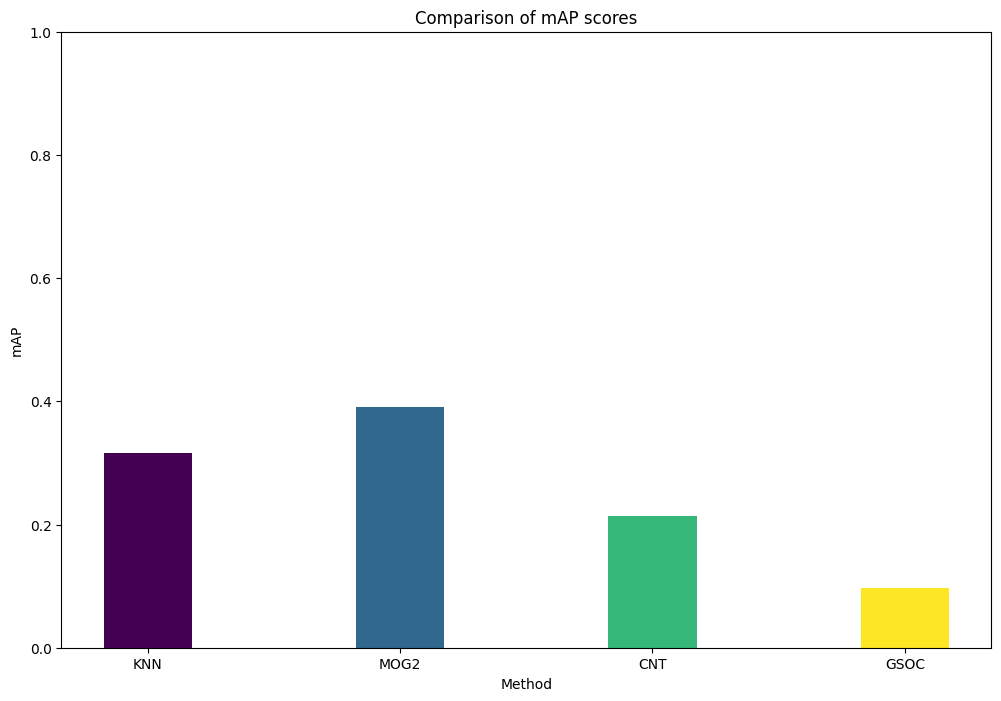

In [2]:
import matplotlib.pyplot as plt

methods = ['KNN', 'MOG2', 'CNT', 'GSOC']
mAP = [mAP_KNN, mAP_MOG2,  mAP_CNT, mAP_GSOC]

# Set the width of the bars
bar_width = 0.35

# Set the x-axis positions of the bars
x_pos = np.arange(len(methods))

# Choose a color map
cmap = plt.get_cmap('viridis')

# Assign a color to each bar
colors = [cmap(i) for i in np.linspace(0, 1, len(x_pos))]


# Create a figure with a larger size
fig = plt.figure(figsize=(12, 8))

# Plot the IoU scores as bars
# plt.bar(x_pos, iou, width=bar_width, label='IoU')

# Plot the mAP scores as bars
plt.bar(x_pos, mAP, width=bar_width, color=colors, label='mAP')



# Add axis labels and a title
plt.xlabel('Method')
plt.ylabel('mAP')
plt.title('Comparison of mAP scores')

# Set the tick labels to be the method names
plt.xticks(x_pos, methods)
# Set the x-axis limits
plt.ylim([0, 1])
# Show the plot
plt.show()